In [69]:
# Import Packages
import numpy as np
import pandas as pd
import tableMakerv2 as tm2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from matplotlib import animation
import time
import re
import warnings
from random import randint
import concurrent
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import ipywidgets as wgt
from Archive import tableMaker as tableMaker

# Reimport changes when editing LiuInt or tableMaker
import importlib
importlib.reload(tm2)

<module 'tableMakerv2' from '/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/tableMakerv2.py'>

# Solver Visualization

## Create reference table, h and c interpolators, and T_func

In [ ]:
if input("Run table generation?") == 'y':
    numXim = 80
    ximLfrac = 0.2
    ximGfrac = 0.4
    numXiv = 20
    path = r"./data/lignellDec1"
    tvals = np.arange(0,11,1)
    Lvals = [0.004, 0.005, 0.006, 0.01, 0.04, 0.1, 0.2, 0.4, 0.8]
    Lbounds = [min(Lvals), max(Lvals)]
    tbounds = [min(tvals), max(tvals)]

    # Make sure Lvals is strictly increasing
    for i in range(len(Lvals)-1):
        if Lvals[i+1] > Lvals[i]:
            pass
        else:
            print(f"NO: {Lvals[i+1]} < {Lvals[i]}")

    #----- Need to generate the tables twice: the first method allows us to get h and c interpolators to create plots later on
    data_output = tm2.get_data_files(path, Lvals, tvals)
    def create_table(args):
        return tm2.makeLookupTable(*args)

    # Prepare arguments for each call
    file_pattern = r'^L.*.dat$'
    c_components = ['H2', 'H2O', 'CO', 'CO2']
    interpKind = 'cubic'
    table_args = [
        (path, Lvals, tvals, file_pattern, c_components, 'T', interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac),
        (path, Lvals, tvals, file_pattern, c_components, 'h', interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac),
        (path, Lvals, tvals, file_pattern, c_components, 'c', interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac),
    ]

    start = time.time()
    # Use ProcessPoolExecutor to run table creation in parallel
    with ProcessPoolExecutor(mp_context=mp.get_context('fork')) as executor:
        futures = {executor.submit(create_table, args): idx for idx, args in enumerate(table_args)}

        results = {}
        for future in concurrent.futures.as_completed(futures):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception as e:
                print(f"Table creation for index {idx} generated an exception: {e}")

    # Unpack results into separate variables
    T_table, T_indices = results[0]
    h_table, h_indices = results[1]
    c_table, c_indices = results[2]

    end = time.time()
    print("Time elapsed creating auxiliary tables:", end - start)

    # Create table
    start = time.time()

    #----- Get function to get T(xim, xiv, h, c)
    T_func = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = True,
                        ximLfrac = ximLfrac, ximGfrac = ximGfrac)

    end = time.time()
    print("Time elapsed creating T_func:", end - start)

/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:128: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b), points = [ξm,])[0]   # ϵ   < ξ < 1-ϵ
/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:128: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b), points = [ξm,])[0]   # ϵ   < ξ < 1-ϵ
/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt

Time elapsed creating auxiliary tables: 1806.3743691444397


/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:128: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b), points = [ξm,])[0]   # ϵ   < ξ < 1-ϵ
/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:128: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b), points = [ξm,])[0]   # ϵ   < ξ < 1-ϵ
/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt

Time elapsed creating T_func: 2361.855246067047


# A Priori ODT Analysis

In [91]:
#----- Get ODT data

# Ignore the first column of each, which are the radial positions
ODThvals = np.loadtxt(r'../tjet_Dec1/fmeans_enth.dat')[:,1:]
ODTcvals = np.loadtxt(r'../tjet_Dec1/fmeans_progvar.dat')[:,1:]
ODTximvals = np.loadtxt(r'../tjet_Dec1/fmeans_mixf.dat')[:,1:]
ODTxivvals = np.loadtxt(r'../tjet_Dec1/fvar_mixf.dat')[:,1:]
ODTTvals = np.loadtxt(r'../tjet_Dec1/fmeans_temp.dat')[:,1:]
ODTxs = np.loadtxt(r'../tjet_Dec1/fmeans_temp.dat')[:,0]
ODTts = np.loadtxt('../tjet_Dec1/list_of_times.dat')

numRads = len(ODThvals)
numTimes = len(ODThvals[0])

In [ ]:
#----- a Priori testing
minODT_T = np.min(ODTTvals)
print(f"Minimum ODT T: {minODT_T}")
if input("Are you sure you want to re-run aPriori?")=='y':
    Tqueried = np.zeros(ODThvals.shape)
    for radInd in range(numRads):
        fracCompleted = radInd/numRads*100
        if fracCompleted%1 <= 0.1 or fracCompleted%0.5 <= 0.1:
            print(f"Working on row {radInd}/{numRads} ({fracCompleted:.1f}% complete)")
        for timeInd in range(numTimes):
            # For each radius and time point, grab the ODT xim, xiv, h, and c values
            h = ODThvals[radInd][timeInd]
            c = ODTcvals[radInd][timeInd]
            xim = ODTximvals[radInd][timeInd]
            xiv = ODTxivvals[radInd][timeInd]

            # Avoid errors due to very small negative values (e.g. -1e-8)
            if xim < 0:
                xim = np.abs(xim)
            if xiv < 0:
                xiv = np.abs(xiv)
            xivmax = xim*(1-xim)
            if xiv > xivmax:
                if xiv-xivmax < 1e-6:
                    print(f"Corrected xiv at rad {radInd}, time {timeInd} from {xiv} to {xivmax}")
                    xiv = xivmax
            if ODTTvals[radInd][timeInd] - minODT_T < 0.5:
                # Flame is essentially not present. Do not query.
                Tqueried[radInd][timeInd] = ODTTvals[radInd][timeInd]
            else:
                # Query the table
                if radInd == 0 and timeInd == 0:
                    Tqueried[radInd][timeInd] = T_func[0](xim, xiv, h, c, useStoredSolution = False)
                else:
                    Tqueried[radInd][timeInd] = T_func[0](xim, xiv, h, c, useStoredSolution = True)
else:
    print("Overridden, a Priori not conducted.")

# Conditions:
#    20 xim, 5 xiv
#    0.2*xim min step
#    Time elapsed: 160 min
# Conditions:
#    80 xim, 20 xiv
#    0.2 min step
#    Time elapsed: 26 min

Minimum ODT T: 299.97414
Working on row 0/1001 (0.0% complete)


/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/tableMakerv2.py:676: UserWarning: NewtonSolve did not fully converge, using case with lowest identified SSE.
  warnings.warn("NewtonSolve did not fully converge, using case with lowest identified SSE.")
/var/folders/55/0qqzz87s5sndf19sv42s64_c0000gq/T/ipykernel_64309/3194580995.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tqueried[radInd][timeInd] = T_func[0](xim, xiv, h, c, useStoredSolution = True)


Working on row 1/1001 (0.1% complete)
Working on row 6/1001 (0.6% complete)
Working on row 11/1001 (1.1% complete)
Working on row 16/1001 (1.6% complete)
Working on row 21/1001 (2.1% complete)
Corrected xiv at rad 23, time 24 from 3.6821608654625156e-08 to 3.1683464196158036e-08
Working on row 26/1001 (2.6% complete)
Working on row 31/1001 (3.1% complete)
Working on row 36/1001 (3.6% complete)
Working on row 41/1001 (4.1% complete)
Working on row 46/1001 (4.6% complete)
Working on row 51/1001 (5.1% complete)
Working on row 56/1001 (5.6% complete)
Working on row 61/1001 (6.1% complete)
Working on row 66/1001 (6.6% complete)
Working on row 71/1001 (7.1% complete)
Working on row 76/1001 (7.6% complete)
Working on row 81/1001 (8.1% complete)
Working on row 86/1001 (8.6% complete)
Working on row 91/1001 (9.1% complete)
Working on row 96/1001 (9.6% complete)
Working on row 101/1001 (10.1% complete)
Working on row 106/1001 (10.6% complete)
Working on row 111/1001 (11.1% complete)
Working on r

 Completed 1001/1001 rows.


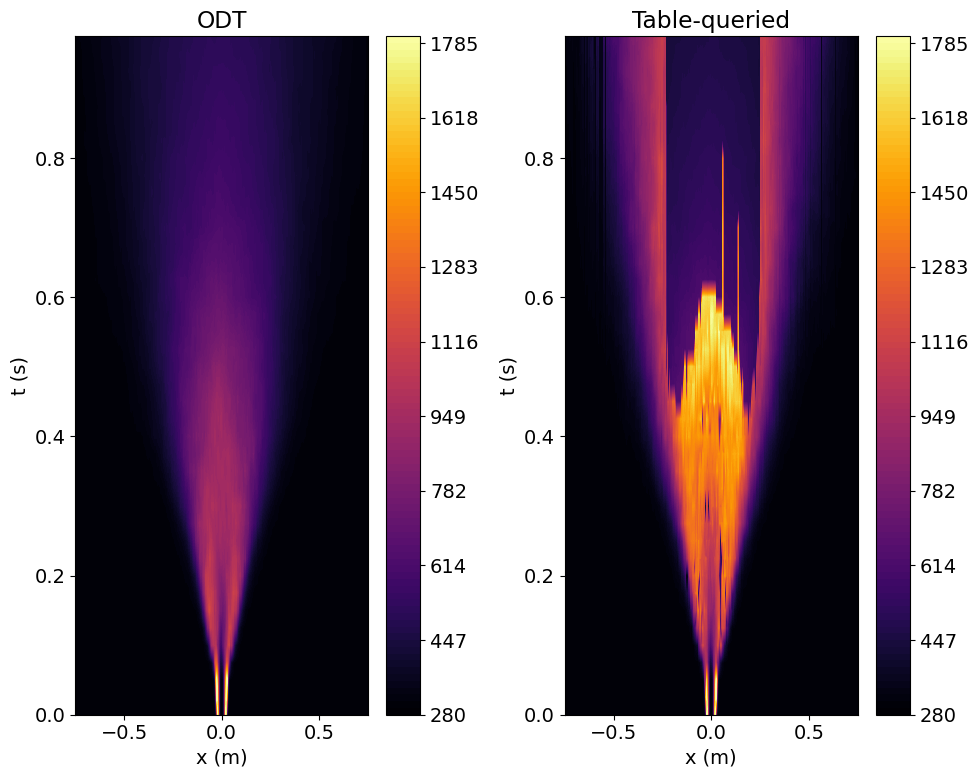

In [26]:
#----- Plot comparison between ODT and a Priori
# In case the analysis was stopped prematurely, display how many rows were queried.
lastCompletedRow = len([Tqueried[i] for i in range(len(Tqueried)) if (Tqueried[i]!=0).all()])
Tqueried_completed = Tqueried[:lastCompletedRow]
print(f" Completed {len(Tqueried_completed)}/{len(ODThvals)} rows.")

# Load data needed for plotting
ODT_Ts = ODTTvals # Get temperature
x = ODTxs         # Get radial positions

levels = np.linspace(280, 1800, 101)
plt.rcParams.update({'font.size': 14})
xx,tt = np.meshgrid(x,ODTts)
fig=plt.figure(figsize=(10,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("ODT")
contour = ax.contourf(xx,tt,ODT_Ts.T,100, cmap='inferno', levels = levels)
plt.colorbar(contour, ax = ax)
ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
ax=plt.subplot(1, 2, 2)
ax.set_title("Table-queried")
contour = ax.contourf(xx, tt, Tqueried_completed.T, 100, cmap = 'inferno', levels = levels)
ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
plt.colorbar(contour, ax = ax)
plt.tight_layout();

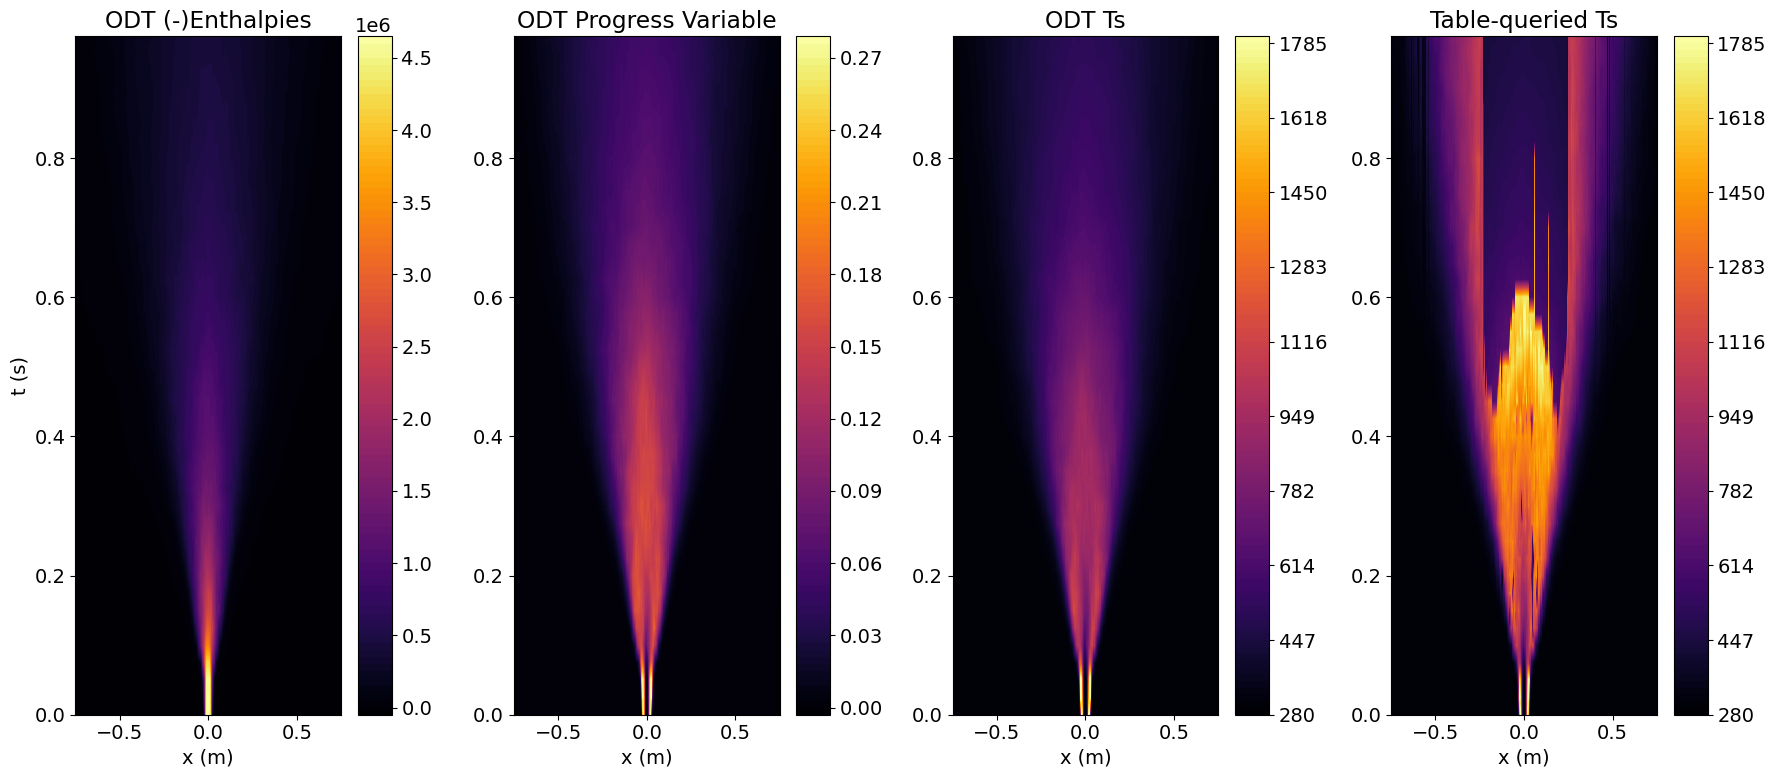

In [27]:
#----- Plot detailed plot with enthalpy and progress variable included
levels = np.linspace(280, 1800, 101)
plt.rcParams.update({'font.size': 14})
fig=plt.figure(figsize=(18,8))
ax = plt.subplot(1, 4, 1)
ax.set_title("ODT (-)Enthalpies")
contour = ax.contourf(xx,tt, -ODThvals.T,100, cmap='inferno')
plt.colorbar(contour, ax = ax)
ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
ax = plt.subplot(1, 4, 2)
ax.set_title("ODT Progress Variable")
contour = ax.contourf(xx,tt, ODTcvals.T,100, cmap='inferno')
plt.colorbar(contour, ax = ax)
ax.set_xlabel('x (m)')
ax = plt.subplot(1, 4, 3)
ax.set_title("ODT Ts")
contour = ax.contourf(xx,tt,ODT_Ts.T,100, cmap='inferno', levels = levels)
plt.colorbar(contour, ax = ax)
ax.set_xlabel('x (m)')
ax=plt.subplot(1, 4, 4)
ax.set_title("Table-queried Ts")
contour = ax.contourf(xx, tt, Tqueried_completed.T, 100, cmap = 'inferno', levels = levels)
ax.set_xlabel('x (m)')
plt.colorbar(contour, ax = ax)
plt.tight_layout();

In [62]:
#----- Locate max h, c, and T in the table.
hInterp = tm2.createInterpolator(h_table, h_indices)
cInterp = tm2.createInterpolator(c_table, c_indices)
ximvals = np.linspace(0,1,10)
xivvals = np.linspace(0,1,10)

if input("Rerun search?") == 'y':
    maxC = 0
    maxCcoords = [0,0,0,0]
    maxH = 0
    maxHcoords = [0,0,0,0]
    maxT = 0
    maxTcoords = [0,0,0,0]
    for ximval in ximvals:
        for xivval in xivvals:
            xivval = ximval*(1-ximval)*xivval
            for lval in Lvals:
                for tval in tvals:
                    cNew = cInterp(ximval, xivval, lval, tval)
                    hNew = hInterp(ximval, xivval, lval, tval)
                    Tnew = T_func[0](ximval, xivval, hNew, cNew)
                    if cNew>maxC:
                        maxC = cNew
                        maxCcoords = [ximval, xivval, lval, tval]
                    if hNew<maxH:
                        maxH = hNew
                        maxHcoords = [ximval, xivval, lval, tval]
                    if Tnew>maxT:
                        maxT = Tnew
                        maxTcoords = [ximval, xivval, lval, tval]

maxCcoords = [float(thing) for thing in maxCcoords]
maxHcoords = [float(thing) for thing in maxHcoords]
maxTcoords = [float(thing) for thing in maxTcoords]

In [63]:
print(f"Max c = {maxC[0]:.4g},     which occurs at {maxCcoords}")
print(f"Max h = {maxH[0]:.4g}, which occurs at {maxHcoords}")
print(f"Max T = {maxT[0]:.4g},       which occurs at {maxTcoords}")
print()
print("Coords are xim, xiv, L, t")

Max c = 0.2822,     which occurs at [0.1111111111111111, 0.0, 0.2, 0.0]
Max h = -4.646e+06, which occurs at [1.0, 0.0, 0.0001, 0.0]
Max T = 1744,       which occurs at [0.1111111111111111, 0.0, 0.008, 0.0]

Coords are xim, xiv, L, t


### A Priori - Single ODT Realization

In [92]:
myPath = r'./aPriori/tjet_many2data/data_py/data_py_00001.npy'
np.load(myPath)

array([[-7.25182454e-001, -7.50000000e-001,  1.17198399e+000, ...,
         2.42045120e-151,  7.67000000e-001,  1.90757688e+003],
       [-6.75455434e-001, -7.00364907e-001,  1.17198399e+000, ...,
         4.62951535e-146,  7.67000000e-001,  1.90757688e+003],
       [-6.25636487e-001, -6.50545960e-001,  1.17198399e+000, ...,
         1.16653454e-141,  7.67000000e-001,  1.90757688e+003],
       ...,
       [ 6.25636812e-001,  6.00727454e-001,  1.17198399e+000, ...,
         2.07692027e-140,  7.67000000e-001,  1.90757688e+003],
       [ 6.75455527e-001,  6.50546170e-001,  1.17198399e+000, ...,
        -2.18703674e-140,  7.67000000e-001,  1.90757688e+003],
       [ 7.25182442e-001,  7.00364885e-001,  1.17198399e+000, ...,
         2.34942890e-152,  7.67000000e-001,  1.90757688e+003]])

## Compare T_func to table values


In [60]:
numCompares = 20
ximLen = len(h_indices[0])
xivLen = len(h_indices[1])
LLen   = len(h_indices[2])
tLen   = len(h_indices[3])

cases = {}
Tcomputed = 0
for i in range(numCompares):
    ximInd = randint(0, ximLen-1)
    xivInd = randint(0, xivLen-1)
    LInd = randint(0, LLen-1)
    tInd = randint(0, tLen-1)
    ximreal = h_indices[0][ximInd]
    xivreal = h_indices[1][xivInd]*ximreal*(1-ximreal)
    Lreal = h_indices[2][LInd]
    treal = h_indices[3][tInd]
    hreal = h_table[ximInd][xivInd][LInd][tInd]
    creal = c_table[ximInd][xivInd][LInd][tInd]
    Treal = T_table[ximInd][xivInd][LInd][tInd]
    warningThrown = False
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        T_computed = T_func[0](ximreal, xivreal, hreal, creal, saveSolverStates = True, useStoredSolution = False)
        if w:
            warningThrown = True

    cases[i] = [ximreal, xivreal, hreal, creal, Lreal, treal, Treal, T_computed[0], ""]
    if np.abs(T_computed-Treal) > 1:
        cases[i][-1] = "T Mismatch"
    if warningThrown:
        cases[i][-1] = "Solver didn't converge"

df = pd.DataFrame(cases, index = ["xim", "xiv", "h", "c", "L", "t", "T", "Tcomputed", "warning"]).T
pd.set_option('display.float_format', '{:.5g}'.format)
df = df.sort_values(by='xim')
df

,xim,xiv,h,c,L,t,T,Tcomputed,warning
11,0,0,1907.6,0,0.006,1,300,300,
0,0.011111,0.0082407,-55805,0.003908,0.12,1,318.16,318.16,
13,0.011111,0.010988,-49734,0,0.12,4,300,300,
9,0.011111,0.010988,-49734,0,0.02,2,300,300,
5,0.033333,0.016111,-2.8657e+05,0.027736,0.2,6,370.54,365.83,Solver didn't converge
10,0.044444,0.021235,-3.4642e+05,0.036164,0.16,4,416.24,416.24,
16,0.066667,0.046667,-3.2652e+05,0.0205,0.008,3,405.89,405.89,
15,0.077778,0.071728,-3.5959e+05,0,0.12,5,300,300,
6,0.088889,0,-5.0907e+05,0.26547,0.006,4,1799.4,1799.4,
1,0.088889,0.040494,-4.51e+05,0.058525,0.0048,7,610.03,611.96,Solver didn't converge


## Functions for creating and plotting contours

In [73]:
def createPlotData(xim, xiv, Ih, Ic, num_points = 100):
    """Creates h and c data for a given:
        xim = mean mixture fraction
        xiv = mixture fraction variance. 
            NOTE: The maximum allowable variance is determined by the mean:
                xiv_max = xim*(1-xim)
        Ih = interpolator for h(xim, xiv, L, t)
        Ic = interpolator for c(xim, xiv, L, t)
            NOTE: both of these interpolators can readily be created with tm2.createInterpolator
        num_points = Resolution of the grid on each axis.
        Lbounds = 2-element array-like containing bounds for L
        tbounds = 2-element array-like containing bounds for t
    Returns:
        [Ls, ts, hs, cs], where
            xs = 2D meshgrid array of L, t values (x when plotting in 3D)
            ys = 2D meshgrid array of t, L values (y when plotting in 3D)
            hs = 2D array of h(L, t)
            cs = 2D array of c(L, t)
    """
    num_points = 100
    Ls = np.linspace(min(Lbounds)+1e-4, max(Lbounds)-1e-4, num_points)
    ts = np.linspace(min(tbounds)+1e-4, max(tbounds)-1e-4, num_points)

    xs, ys = np.meshgrid(Ls, ts)
    hs = np.zeros_like(xs)
    cs = np.zeros_like(xs)

    for i in range(num_points):
        for j in range(num_points):
            hs[i, j] = Ih(xim, xiv, xs[i, j], ys[i, j])[0]
            cs[i, j] = Ic(xim, xiv, xs[i, j], ys[i, j])[0]

    return [xs, ys, hs, cs, xim, xiv]

def plotHCLT(hknown, cknown, xs, ys, hs, cs, xim, xiv, scatterData = None,
             save:bool = True, figsize = (20,20), nameAddition = None, 
             fontscalar = 1.5, fig = None):
    """Creates a 3D plot of h(L, t) and c(L, t), as well as a 2D plot showing the
    contour plots of hknown and cknown. The objective is to show visually the space
    within which a given instance of the NewtonSolver in tableMakerv2 is working.
    Inputs:
        hknown = desired value of enthalpy
        cknown = desired value of progress variable
        Ls = 1st array returned from createPlotData
        ts = 2nd array returned from createPlotData
        hs = 3rd array returned from createPlotData
        cs = 4th array returned from createPlotData
        xim = 5th output returned from createPlotData (mean mixture fraction)
        xiv = 5th output returned from createPlotData (mixture fraction variance)
        scatterData = array of points to show on the (L,t) plot
        save:bool = If set to False, the plot will not be saved as a png, only displayed.
        figsize = (width, height) of the plot in inches. May be set to 'None'
        nameAddition = string to be appended to file name.
        fontscalar = multiplier to control font size. The default value is 1.5, meaning the 
            plot will have a fontsize 1.5x that of the matplotlib default.
        fig = matplotlib figure object. Used for animation.
    Outputs:
        None
    """
    #----- General Formatting
    if fig is None:
        fig = plt.figure(figsize = figsize)
    if fig is not None:
        fig.clf()
    ccol = 'r'  # Color of the progress variable contour
    hcol = 'b'  # Color of the enthalpy contour
    alpha = 0.7 # Surface transparency
    fontsize = int(10*fontscalar)
    plt.rcParams.update({'font.size': fontsize})  # Global font size update
    pad = fontsize/15.*10

    #----- Plot Progress Variable
    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(xs,ys,cs, cmap='viridis', alpha = alpha)

    #Add contours
    ax.contour(xs, ys, cs, zdir='z', levels=[cknown], colors=ccol, linestyles = 'dashed')
    ax.contour(xs, ys, cs, zdir='z', levels=[cknown], colors=ccol, offset = ax.get_zlim()[0],\
               alpha = alpha, linestyles = 'solid')

    #Formatting
    ax.set_title("Progress Variable (L,t)")
    ax.text2D(0.5, 0.95, f'Contour: c* = {cknown:.4g}', transform=ax.transAxes, ha='center')
    ax.set_xlabel("L", labelpad = pad)
    ax.set_xticks(np.arange(0, 0.201, 0.05))
    ax.set_xlim((0,0.2))
    ax.set_ylabel("t", labelpad = pad)
    ax.set_zlabel("c", labelpad = 2*pad)
    ax.tick_params(axis='z', pad = 10)
    ax.view_init(30, 110)
    ax.text(ax.get_xlim()[0]*2.5, ax.get_ylim()[0], ax.get_zlim()[1]*1.3,
            f"xim = {xim:.3g}\nxiv = {xiv:.3g}", bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle='round'))
    
    #----- Plot Enthalpy
    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(xs, ys, hs, cmap='inferno', alpha = alpha)

    #Add contours
    ax.contour(xs, ys, hs, zdir='z', levels=[hknown], colors=hcol, linestyles = 'dashed')
    ax.contour(xs, ys, hs, zdir='z', levels=[hknown], colors=hcol, offset = ax.get_zlim()[0],\
               alpha = alpha, linestyles = 'solid')

    #Formatting
    ax.set_title("Enthalpy (L,t)")
    ax.text2D(0.5, 0.95, f'Contour: h* = {hknown:.4g}', transform=ax.transAxes, ha='center')
    ax.set_xlabel("L", labelpad=10)
    ax.set_xticks(np.arange(0, 0.201, 0.05))
    ax.set_xlim((0,0.2))
    ax.set_ylabel("t", labelpad = pad)
    ax.set_zlabel(r"h", labelpad = 2*pad, rotation = 0)
    ax.tick_params(axis='z', pad = 10)
    ax.ticklabel_format(axis = 'z', style = 'sci', useMathText = True, scilimits = (-1, 1))
    ax.zaxis.get_offset_text().set_visible(False)
    exponent = int(f'{np.min(hs):.2e}'.split('e')[1])
    zlim = ax.get_zlim()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0]*1.5, ylim[0], zlim[1] + (zlim[1]-zlim[0])/6,
            '$\\times\\mathdefault{10^{%d}}\\mathdefault{}$' % exponent)
    ax.view_init(30, 110)

    #----- Plot Projections Only
    ax = fig.add_subplot(133)

    #Get projection data
    ax.contour(xs, ys, cs, levels = [cknown], colors = ccol, linestyles = 'solid')
    ax.contour(xs, ys, hs, levels = [hknown], colors = hcol, linestyles = 'solid')
    if scatterData is not None:
        try:
            xDat = np.array(scatterData)[:,0]
            yDat = np.array(scatterData)[:,1]
            scat, = ax.plot(xDat, yDat, '*', color = 'black', label = "Solver")
        except Exception as e:
            print(e)
            raise ValueError("Could not plot scatter data. Ensure data array is formatted correctly")
    ax.set_title("h & c contours")
    ax.set_xlabel("L", labelpad = pad)
    ax.set_xticks(np.arange(0, 0.201, 0.05))
    ax.set_xlim((0,0.2))
    ax.set_ylabel("t", rotation = 0, labelpad = pad)
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.set_box_aspect(1)
    ax.invert_xaxis()
    ax.invert_yaxis()
    legend_elements = [
        Line2D([0], [0], color=ccol, label="Progress Variable (c)"),
        Line2D([0], [0], color=hcol, label="Enthalpy (h)"),
    ]
    if scatterData is not None:
        legend_elements.append(scat)

    #----- Add legend with the proxy artists
    ax.legend(handles=legend_elements)

    #----- Save and show final result
    plt.tight_layout(pad = 5)
    if save:
        if nameAddition is not None:
            addition = f"_{nameAddition}"
        else:
            addition = ""
        plt.savefig(f'HCLT_c_{cknown:.4g}_h_{hknown:.4g}{addition}.png',bbox_inches='tight')  # Save as a PNG file

## Plotting the Contours

/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/tableMakerv2.py:672: UserWarning: NewtonSolve did not fully converge, using case with lowest identified SSE.
  warnings.warn("NewtonSolve did not fully converge, using case with lowest identified SSE.")


Indices:
Radial: 512
Time  : 0

Result:
xim = 0.0584
xiv = 8.67e-18
h   = -5.5e+05
c   = 0.274
T_table = 1971 K
T_ODT   = 2121 K


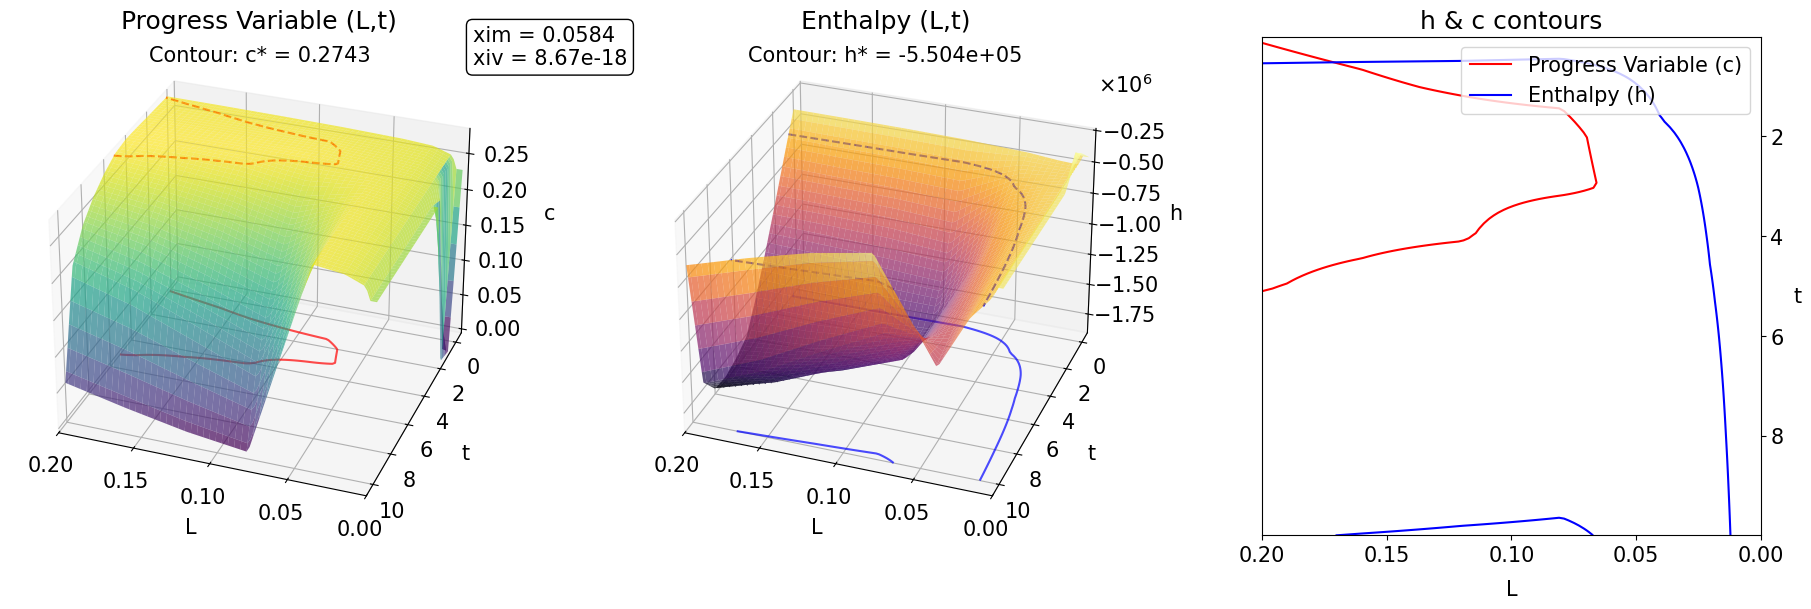

In [74]:
#----- Plot a point from the ODT data
ODThvals = np.loadtxt(r'../tjet/fmeans_enth.dat')[:,1:-1]
ODTcvals = np.loadtxt(r'../tjet/fmeans_progvar.dat')[:,1:-1]
ODTximvals = np.loadtxt(r'../tjet/fmeans_mixf.dat')[:,1:-1]
ODTxivvals = np.loadtxt(r'../tjet/fvar_mixf.dat')[:,1:-1]
ODTTvals = np.loadtxt(r'../tjet/fmeans_temp.dat')[:,1:-1]

numRads = len(ODThvals)
numTimes = len(ODThvals[0])

radLoc = 51.2 # percent through whole domain
tLoc   = 0 # percent through whole domain
radInd = int(numRads*radLoc/100)
tInd   = int(numTimes*tLoc/100)

xim = np.abs(ODTximvals[radInd][tInd])
xiv = np.abs(ODTxivvals[radInd][tInd])
h   = ODThvals[radInd][tInd]
c   = ODTcvals[radInd][tInd]
T_ODT = ODTTvals[radInd][tInd]
T_tablequeried = T_func[0](xim, xiv, h, c, useStoredSolution = False)[0]
print("Indices:")
print(f"Radial: {radInd}")
print(f"Time  : {tInd}")
print()
print("Result:")
print(f"xim = {xim:.3g}")
print(f"xiv = {xiv:.3g}")
print(f"h   = {h:.3g}")
print(f"c   = {c:.3g}")
print(f"T_table = {T_tablequeried:.4g} K")
print(f"T_ODT   = {T_ODT:.4g} K")

#----- Create plot
hknown = h
cknown = c
Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, save =  False)

## Animations

### Animate over xim and xiv

In [ ]:
#----- Animate over xim and xiv
if input("Create animation over xim and xiv?")=='y':
    # Create data
    xim = 0.25
    xiv = 0.25*xim*(1-xim)

    # Create data and plot
    Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
    hknown = -4.0e6
    cknown = 0.24
    xims = np.linspace(0, 1, 10)
    xivFracs = np.linspace(0, 1, 10)

    fig = plt.figure(figsize = (20,20))
    # Function to animate the plot
    def animate(frame):
        ximInd = frame//len(xims)
        xivInd = frame%len(xims)
        print(f"Progress: {(ximInd/len(xims)+xivInd/len(xivFracs)/10)*100:.2f}%")
        xim = xims[ximInd]
        xiv = xim*(1-xim)*xivFracs[xivInd]
        Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
        plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, save = False, fig = fig)

    # Create the animation
    plt.ioff()
    ani = animation.FuncAnimation(fig, animate, frames=len(xims)**2, interval = 50)

    # Save the animation as a GIF
    ani.save(f"xim_xiv_Animation.gif", writer='pillow', fps=5)
    plt.ion()

### Incorrect Solve

Check vals:  0.19 0.07695 -929600.0 0.005942


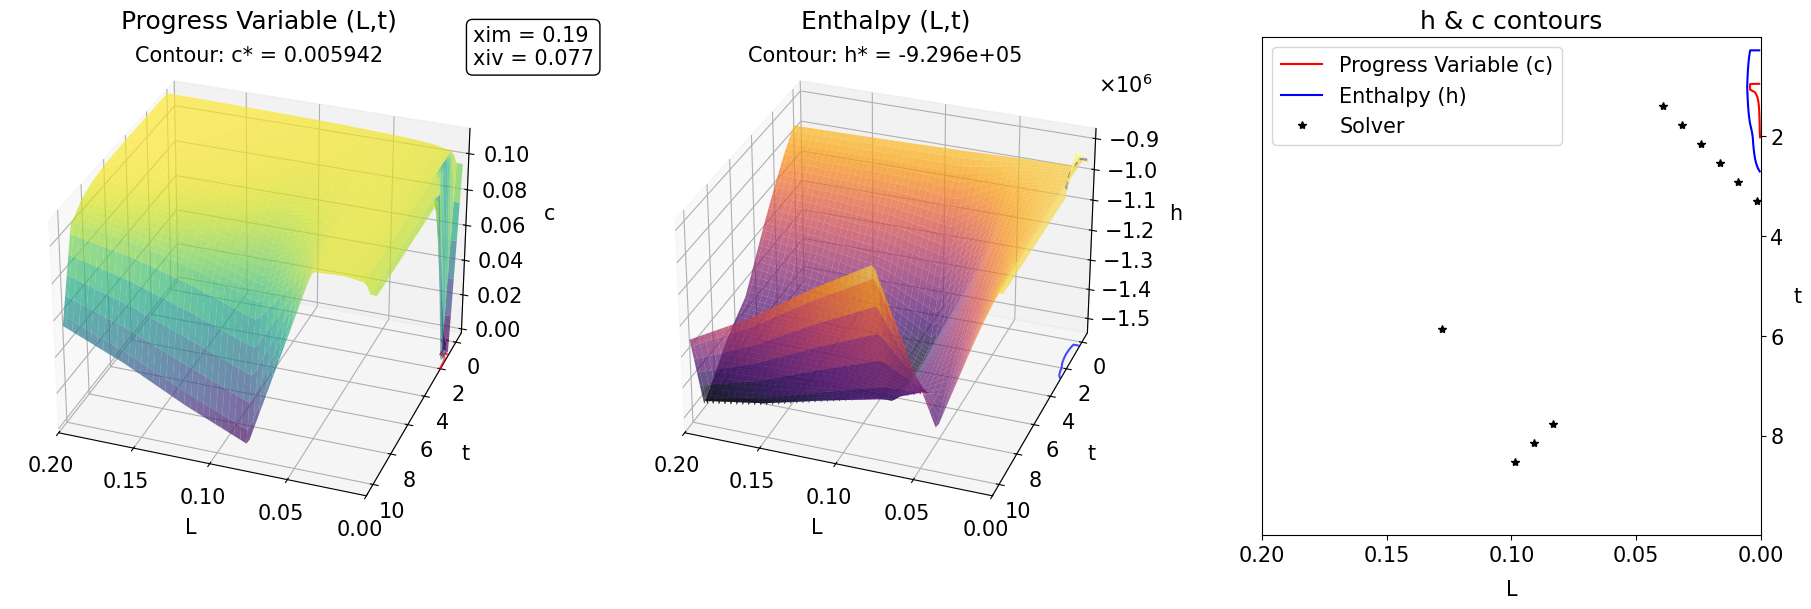

In [75]:
if input("Create animation of incorrect solve?")=='y':
    # Load in solver data
    solverDataFolder = r'./solver_data/20241119/Fail/'
    solverFilename = r'Xim_0.19_Xiv_0.07695_h_-9.296e+05_c_0.005942.txt'
    solverDataPath = solverDataFolder+solverFilename
    solverData = np.loadtxt(solverDataPath, dtype = float)

    # Parse solver data
    LSolver   = solverData[:,2]
    tSolver   = solverData[:,3]
    errSolver = solverData[:,4]

    # Parse data from file name
    pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
    matches = re.findall(pattern, solverFilename)
    solverInfo = {label: float(value) for label, value in matches}
    ximSolver = solverInfo['Xim']
    xivSolver = solverInfo['Xiv']
    hSolver   = solverInfo['h']
    cSolver   = solverInfo['c']
    print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

    # Create data and plot
    scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
    Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp)

    fig = plt.figure(figsize = (20,20))
    # Function to animate the plot
    def animate(frame):
        previousPointsToShow = 10
        low = frame+1-previousPointsToShow
        if low < 0:
            low = 0
        plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, scatterData[low:frame+1], save = False, fig = fig)

    # Create the animation
    plt.ioff()
    ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

    # Save the animation as a GIF
    ani.save(f'solverAnimation_failure.gif', writer='pillow', fps=5)
    plt.ion()

### T mismatch

Check vals:  0.75 0.046875 -596200.0 0.09023


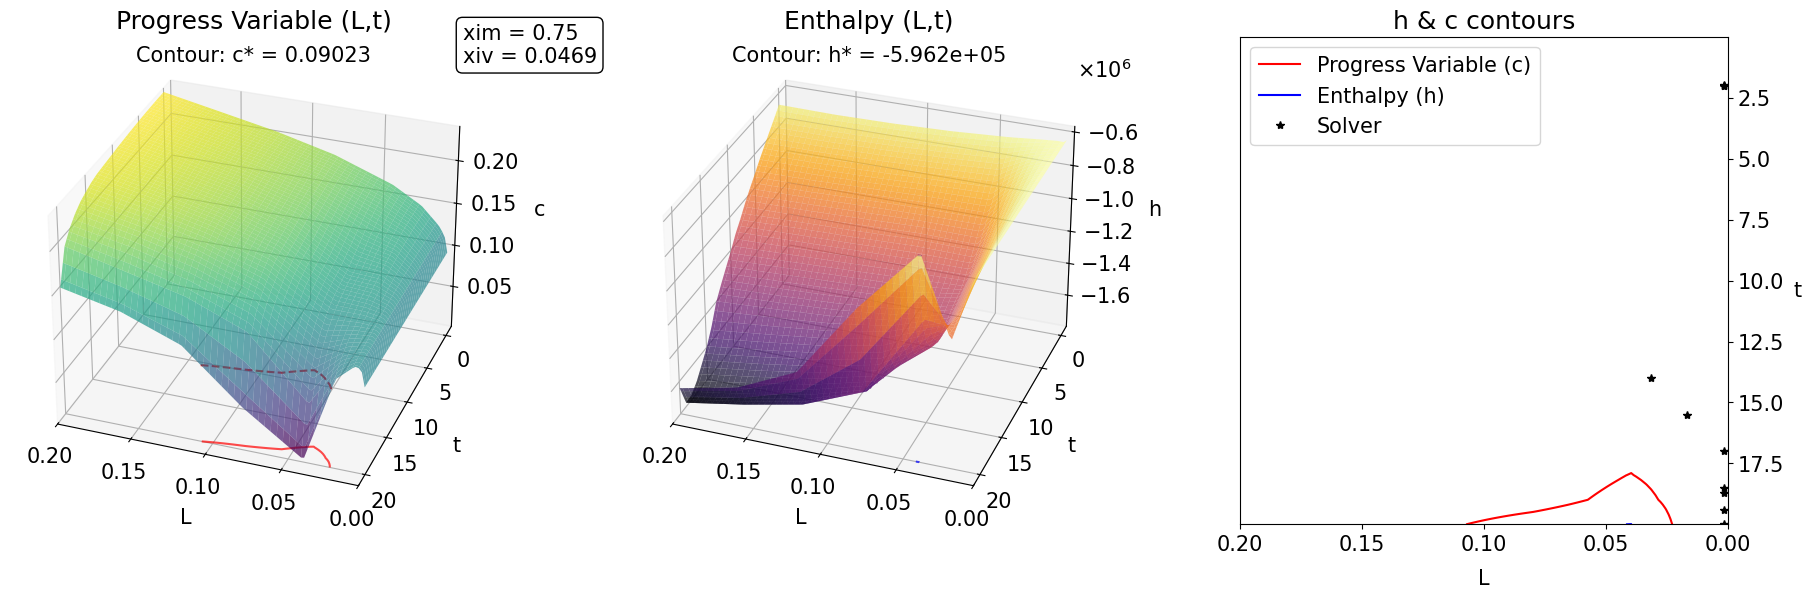

In [69]:
# Load in solver data
solverDataFolder = r'./solver_data/20241017/Tmismatch/'
solverFilename = r'Xim_0.75_Xiv_0.046875_h_-5.962e+05_c_0.09023.txt'
solverDataPath = solverDataFolder+solverFilename
solverData = np.loadtxt(solverDataPath, dtype = float)

# Parse solver data
LSolver   = solverData[:,2]
tSolver   = solverData[:,3]
errSolver = solverData[:,4]

# Parse data from file name
pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
matches = re.findall(pattern, solverFilename)
solverInfo = {label: float(value) for label, value in matches}
ximSolver = solverInfo['Xim']
xivSolver = solverInfo['Xiv']
hSolver   = solverInfo['h']
cSolver   = solverInfo['c']
print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

# Create data and plot
scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp)

fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    previousPointsToShow = 10
    low = frame+1-previousPointsToShow
    if low < 0:
        low = 0
    plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, scatterData[low:frame+1], save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

# Save the animation as a GIF
ani.save(f'solverAnimation_Tmismatch.gif', writer='pillow', fps=5)
plt.ion()

### Correct solve

Check vals:  0.25 0.046875 -1000000.0 0.145


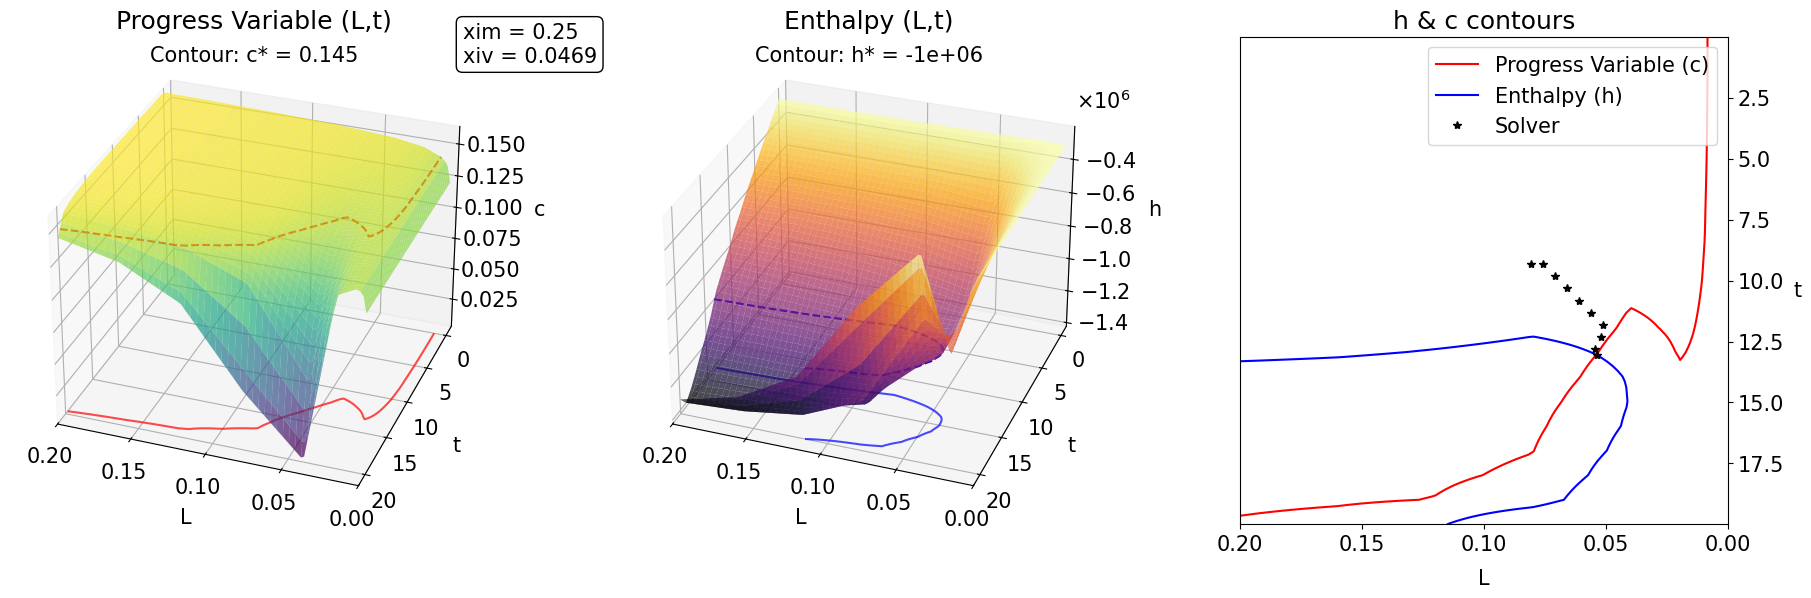

In [84]:
# Load in solver data
solverDataFolder = r'./solver_data/20241017/Success/'
solverFilename = r'Xim_0.25_Xiv_0.046875_h_-1e+06_c_0.145.txt'
solverDataPath = solverDataFolder+solverFilename
solverData = np.loadtxt(solverDataPath, dtype = float)

# Parse solver data
LSolver   = solverData[:,2]
tSolver   = solverData[:,3]
errSolver = solverData[:,4]

# Parse data from file name
pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
matches = re.findall(pattern, solverFilename)
solverInfo = {label: float(value) for label, value in matches}
ximSolver = solverInfo['Xim']
xivSolver = solverInfo['Xiv']
hSolver   = solverInfo['h']
cSolver   = solverInfo['c']
print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

# Create data and plot
scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp)

fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    previousPointsToShow = 10
    low = frame+1-previousPointsToShow
    if low < 0:
        low = 0
    plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, scatterData[low:frame+1], save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

# Save the animation as a GIF
ani.save(f'solverAnimation_success.gif', writer='pillow', fps=5)
plt.ion()

### Animate h*, c*

In [1]:
# Create data
xim = 0.25
xiv = 0.25*xim*(1-xim)

# Create data and plot
scatterData = [[0.1, 6], [0.09, 4], [0.16, 8]]
scatterData = None
Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
hknowns = np.linspace(np.max(hs), np.min(hs), 20)
cknowns = np.linspace(np.max(cs), np.min(cs), 20)


fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    if frame < len(hknowns):
        hknown = hknowns[frame]
        cknown = cknowns[4]
    else:
        hknown = hknowns[10]
        cknown = cknowns[frame-len(hknowns)]
    plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=19*2, interval = 200)

# Save the animation as a GIF
ani.save(f"hcAnimation.gif", writer='pillow', fps=5)
plt.ion()

NameError: name 'createPlotData' is not defined

# AICHE Regionals - A Priori Analysis

In [ ]:
#----- Import DOL-processed data
cols = "r, F, Frms, C, H, T, O2, N2, H2, H2O, CH4, CO, CO2, OH, NO" #from data file
ximcol = 1
xivcol = 2
hcol = 4
ccol = 3
tcol = 5

fileNames = [r"D075.Yall_proc", r"D30.Yall_proc", r"D60.Yall_proc", \
             r"D15.Yall_proc", r"D45.Yall_proc", r"D75.Yall_proc"]
filePath = r"./aPriori/processed/pmD.scat/"

# Storage arrays
t_table_data_all = np.empty(len(fileNames), dtype=np.ndarray)
data = np.empty((len(fileNames)), dtype=np.ndarray)

for j in range(len(fileNames)):                # For each file,
    netPath = filePath+fileNames[j]            # Get the path to the file,
    data[j] = np.loadtxt(netPath)[1:-1].T      # Load the file
    # NOTE: Indexing piece in the middle avoids xim=0
    t_data_table = np.ones(len(data[j][0]))*-1 # Initialize to store table-computed data
    
    for i in range(len(data[j][0])):
        xim = data[j][ximcol][i]
        xiv = data[j][xivcol][i]
        h   = data[j][hcol][i]
        c   = data[j][ccol][i]
        t_data_table[i] = T_table(xim, xiv, h, c)
    t_table_data_all[j] = t_data_table

print('done')

In [ ]:
colors = ['#FF0000', '#FFA500', '#00FF00', '#0000FF', '#4B0082', '#000000']

omit = 0 #number of plots to show simultaneously
for i in range(len(data)-omit):
    t_data_experiment = data[i][tcol]
    r = data[i][0]
    plt.plot(r, t_data_experiment, 'o', \
             color = colors[i])
    plt.plot(r, t_table_data_all[i], label = f"{fileNames[i]}", \
             color = colors[i])
plt.title("Table vs. Experiment")
plt.ylabel("Temperature (K)")
plt.xlabel(r"Radial Position")
plt.xlim((0,75))
plt.ylim((0,2000))
plt.legend();
print("""Dots = Experimental
Lines = Table""")

# Plotting T with Fixed $\xi_m$, $\xi_v$
Old code for conceptual review

## Plotting

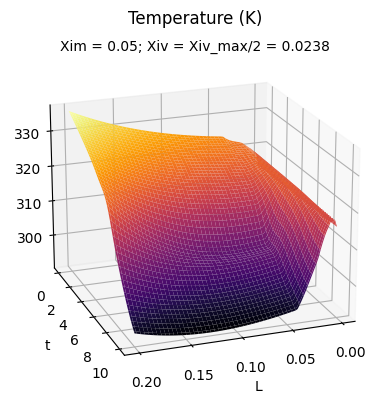

In [100]:
# Generate data
ximT = 0.05
xivT = ximT*(1-ximT)/2 #1/2 of max variance
num_points = 100
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros_like(x)

for i in range(num_points):
    for j in range(num_points):
        Ts[i, j] = It(xim, xiv, xT[i, j], yT[i, j])

# Plot data
zdata = Ts
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim = 30)
ax.set_title("Temperature (K)")
ax.set_xlabel("L")
ax.set_ylabel("t")
ax.view_init(20, 70)
ax.set_zlim(bottom=np.min(zdata), top=np.max(zdata))
ax.plot_surface(xT, yT, zdata, cmap='inferno')
ax.text2D(0.5, 0.95, rf'Xim = {ximT:.2f}; Xiv = Xiv_max/2 = {xivT:.4f}', transform=ax.transAxes, ha='center')

plt.savefig(f'./figures/3DTemperature_xim_{ximT:.2f}_xiv_{xivT:.4f}.png',bbox_inches='tight')  # Save as a PNG file

## Animating

In [96]:
#Create Data
ximTarr = np.linspace(0.01, 0.99, 10)
xivTarr = ximTarr*(1-ximTarr)/2 #1/2 of max variance
num_points = 30
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros((len(ximTarr), len(Ls), len(ts)))

for k in range(len(ximTarr)):
    xim = ximTarr[k]
    xiv = xivTarr[k]
    print(k)
    for i in range(num_points):
        for j in range(num_points):
            Ts[k,i,j] = It(xim, xiv, xT[i, j], yT[i, j])

0
1
2
3
4
5
6
7
8
9


Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  0


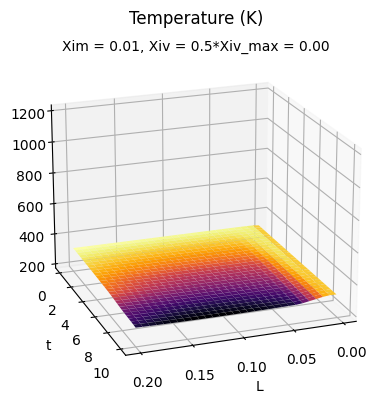

In [97]:
#Animate
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

animData = Ts
# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(animData):
        frame = 2*len(animData)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.set_title("Temperature (K)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.view_init(20, 70)
    ax.set_zlim(bottom=np.min(animData), top=np.max(animData))
    surf = ax.plot_surface(xT, yT, animData[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {ximTarr[frame]:.2f}, Xiv = 0.5*Xiv_max = {xivTarr[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(animData), interval=200)

# Save the animation as a GIF
ani.save(f'Temperature_VariableXimXiv.gif', writer='pillow', fps=5)

## Interactive Plots

In [10]:
#----- Interactive plots
def interact1(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z1, cmap='inferno')
    contour_lines = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.view_init(theta, phi)
    plt.show();

def interact2(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z2, cmap='viridis')
    contour_lines = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    
    ax.view_init(theta, phi)
    plt.show();


#wgt.interact(interact1, theta=(0,90), phi=(0,360), z)
wgt.interact(interact2, theta=(0,90), phi=(0,360), z = np.arange(0.01, 0.13, 0.01))

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

<function __main__.interact2(theta, phi, z)>

# Archive

## tm2 Testing

Code in this block was used to confirm allignment between version of the tableMaker code.

### Generate tables

#### Old Code - Serial

In [ ]:
# OLD CODE: tableMaker
# NOTE: "OS" = 'old, Serial'

start = time.time()

numXim = 5
numXiv = 5
path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

data_output_old = tableMaker.get_data_files(path, Lvals, tvals)

#----- Create T Table
table_OS, indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='T',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)
h_table_OS, h_indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='h',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)
c_table_OS, c_indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='c',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)

end = time.time()
print(end-start)

# Testing the new code 
It_OS = tableMaker.createInterpolator(table_OS, indices_OS)
Ih_OS = tableMaker.createInterpolator(h_table_OS, h_indices_OS)
Ic_OS = tableMaker.createInterpolator(c_table_OS, c_indices_OS)

#----- Define function to get T(xim, xiv, h, c) from table (OLD METHOD)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
    
def T_table_OS(xim, xiv, h, c):
    L,t = tableMaker.Lt_hc(h, c, xim, xiv, Ih_OS, Ic_OS, Lbounds, tbounds)
    return It_OS(xim, xiv, L, t)

/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:86: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b))[0]   # ϵ   < ξ < 1-ϵ


KeyboardInterrupt: 

#### Old Code - Parallel

In [ ]:
# OLD CODE: tableMaker
start = time.time()

def create_table(args):
    path, Lvals, tvals, phi, numXim, numXiv, data_output_old = args
    return tableMaker.makeLookupTable(path, Lvals, tvals, phi=phi,
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)
numXim = 5
numXiv = 5
data_output_old = tableMaker.get_data_files(path, Lvals, tvals)

# Prepare arguments for each call
table_args = [
    (path, Lvals, tvals, 'T', numXim, numXiv, data_output_old),
    (path, Lvals, tvals, 'h', numXim, numXiv, data_output_old),
    (path, Lvals, tvals, 'c', numXim, numXiv, data_output_old),
]

# Use ProcessPoolExecutor to run table creation in parallel
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(create_table, args): idx for idx, args in enumerate(table_args)}

    results = {}
    for future in concurrent.futures.as_completed(futures):
        idx = futures[future]
        try:
            results[idx] = future.result()
        except Exception as e:
            print(f"Table creation for index {idx} generated an exception: {e}")

# Unpack results into separate variables
table_OP, indices_OP = results[0]
h_table_OP, h_indices_OP = results[1]
c_table_OP, c_indices_OP = results[2]

end = time.time()
print(end-start)

# Testing the new code 
It_OP = tableMaker.createInterpolator(table_OP, indices_OP)
Ih_OP = tableMaker.createInterpolator(h_table_OP, h_indices_OP)
Ic_OP = tableMaker.createInterpolator(c_table_OP, c_indices_OP)

#----- Define function to get T(xim, xiv, h, c) from table (OLD METHOD)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
    
def T_table_OP(xim, xiv, h, c):
    L,t = tableMaker.Lt_hc(h, c, xim, xiv, Ih_OP, Ic_OP, Lbounds, tbounds)
    return It_OP(xim, xiv, L, t)

83.65903663635254


#### New Code - Serial

In [ ]:
# NEW CODE: tm2
start = time.time()

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

#----- Get function to get T(xim, xiv, h, c) (NEW METHOD)
T_table_NS = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = False)

end = time.time()
print(end - start)

199.90124535560608


#### New Code - Parallel

In [ ]:
# NEW CODE: tm2
start = time.time()

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

#----- Get function to get T(xim, xiv, h, c) (NEW METHOD)
T_table_NP = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = True)

end = time.time()
print(end - start)

80.75290322303772


In [ ]:
# Testing - trying to handle error with singular Jacobian
T_table_NP[0](0, 0, -7178.7 , 0)

array([291.])

### Compare new vs. old $T(\bar{\xi})$

In [ ]:
# For a number of points, 
# Determine the "real" value by grabbing it from a table
# Pass the table parameters into each interpolator
# Compare accuracy
from random import randint

numCompares = 10
ximLen = len(h_indices_OS[0])
xivLen = len(h_indices_OS[1][0])
LLen   = len(h_indices_OS[2])
tLen   = len(h_indices_OS[3])

for i in range(numCompares):
    ximInd = randint(0, ximLen-1)
    xivInd = randint(0, xivLen-1) # zero variance case led to some issue...
    LInd = randint(0, LLen-1)
    tInd = randint(0, tLen-1)
    ximreal = h_indices_OS[0][ximInd]
    xivreal = h_indices_OS[1][ximInd][xivInd]
    Lreal = h_indices_OS[2][LInd]
    treal = h_indices_OS[3][tInd]
    hreal = h_table_OS[ximInd][xivInd][LInd][tInd]
    creal = c_table_OS[ximInd][xivInd][LInd][tInd]
    Treal = table_OS[ximInd][xivInd][LInd][tInd]

    print(f"Conditions: xim = {ximreal}, xiv = {xivreal}, hreal = {hreal:.5g}, creal = {creal:.5g}")
    print(f"             L = {Lreal}, t = {treal}, T = {Treal}")
    OS = T_table_OS(ximreal, xivreal, hreal, creal)
    OP = T_table_OP(ximreal, xivreal, hreal, creal)
    NS = T_table_NS[0](ximreal, xivreal, hreal, creal)
    NP = T_table_NP[0](ximreal, xivreal, hreal, creal)
    print(f"OS: {OS:.5g}")
    print(f"OP: {OP:.5g}")
    print(f"NS: {NS[0]:.10g}")
    print(f"NP: {NP[0]:.10g}")
    print()


KeyboardInterrupt



## (L, t) -> (h,c) algorithm (tableMaker code)

### Create tables

In [ ]:
#Table Test: time the creation of a temperature table 
from Archive import tableMaker as tableMaker   
import time

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

data_output = tm2.get_data_files(path, Lvals, tvals)

#----- Create T Table
start = time.process_time()
table, indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='T', 
                                           get_data_files_output = data_output)
elapsed = (time.process_time()-start)
print(f"Time elapsed to process temperature table = {elapsed:.2f} seconds")

#----- Create h & c tables
h_table, h_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='h', 
                                           get_data_files_output = data_output)
c_table, c_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='c', 
                                           get_data_files_output = data_output)
print('h & c tables complete')

Time elapsed to process temperature table = 27.43 seconds
h & c tables complete


### Interpolator testing

In [ ]:
# Test the Interpolator
Ih = tableMaker.createInterpolator(h_table, h_indices)
Ic = tableMaker.createInterpolator(c_table, c_indices)
It = tableMaker.createInterpolator(table, indices)

print(h_indices)
#---------------
print("h test:")
xim = 0.25
xiv = 0.25*xim*(1-xim)
L = 0.002
t = 5
htest = h_table[1][1][3][5]
print(htest) 
print(Ih(xim, xiv, L, t))
print()

print("c test:")
ctest = c_table[1][1][3][5]
print(ctest)
print(Ic(xim, xiv, L, t))
print()

print("T test:")
ttest = table[1][1][3][5]
print(ttest)
print(It(xim, xiv, L, t))
print()

print("If values above are equivalent, the interpolator is working as expected.")

[array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([[0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.0625  , 0.125   , 0.1875  , 0.25    ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.      , 0.      , 0.      , 0.      ]]), [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2], array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]
h test:
-286731.75702770625
-286731.7606373748

c test:
0.13368329603843968
0.13368329976183368

T test:
1148.8296645257617
1148.829689572824

If values above are equivalent, the interpolator is working as expected.


### (h,c) $\rightarrow$ (L,t) test

In [ ]:
importlib.reload(tm2)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
hval = htest
cval = ctest+0.001
norm = np.max(h_table)/np.max(c_table)

ans = tm2.Lt_hc_newton(hval, cval, xim, xiv, Ih, Ic, Lbounds, tbounds, norm = norm)

print()
print(f"Goal L = {L:.6f} | Solved L = {ans[0]:.6f}")
print(f"Goal t = {t:.6f} | Solved t = {ans[1]:.6f}")
print()

print("If the values above match, the algorithm found a table value.")
print("If the values above don't match exactly but no error was thrown, then the solver might have found another solution.")


Goal L = 0.002000 | Solved L = 0.002276
Goal t = 5.000000 | Solved t = 2.524780

If the values above match, the algorithm found a table value.
If the values above don't match exactly but no error was thrown, then the solver might have found another solution.


## extractContour Function

In [ ]:
def extractContour(zval, data):
    """
    Extracts the contour line data for Z = z(x,y). 
    Inputs: 
        zval: contour's value of z
        data: tuple or array with 3 elements (in order):
            X: meshed array of x data points (2D
            Y: meshed array of y data points (2D)
                NOTE: xdata, ydata = np.meshgrid(xdata ydata)
            Z: array of z data points (2D)
    Outputs: 
        lines: numpy array of points [x,y,z] 
    Example usage: 
        >>> zval   = 0.10
        >>> X, Y   = np.meshgrid(xdata, ydata)
        >>> data   = (X, Y, zdata)
        >>> points = extractContour(zval, data)
        >>> fig    = plt.figure()
        >>> ax     = fig.add_subplot(111, projection='3d')
        >>> ax.scatter(points[:,0], points[:,1], points[:,2])
    """
    xdat, ydat, zdat = data
    X, Y = np.meshgrid(xdat, ydat)
    contour_lines = plt.contour(xdat, ydat, zdat, levels = (zval,))

    # Find intersection points of contour lines with the plane
    lines = []
    for line_collection in contour_lines.collections:
        for path in line_collection.get_paths():
            vertices = path.vertices
            for point in vertices:
                xpt, ypt = point
                lines.append([xpt, ypt, zval])

    plt.close()
    return np.array(lines)

## Making a Jacobian calculator
This code is now implemented in tm2. This was coded outside of the main code so that I could benchmark it against sympy's existing jacobian calculator. Result: manually-coded solution is ~10x faster

In [ ]:
def getJac(F, X):
    """Computes the 2x2 Jacobian of F(X) at X
    NOTE: This function assumes constant xim and xiv. These parameters are included in F and X
            to allow a generic function to be used.
    Params:
        F: f(mvlt) = [h(mvlt), c(mvlt)]
            def F(mvlt):
                return np.array([hInterp(*mvlt), cInterp(*mvlt)])
        X: [xim, xiv L, t]
    Returns:
        J: [[dH/dL  dH/dt],
            [dc/dL  dc/dt]]
    """
    # Confirm X is an array
    X = np.array(X)

    # Get initial point
    F0 = F(X)

    # Set deltas
    eps = 1e-16 # machine precision
    scalar = np.sqrt(eps)
    deltaL = np.array([0, 0, X[2]*scalar, 0])
    deltat = np.array([0, 0, 0, X[3]*scalar])
    
    # Compute gradients
    J0 = (F(X + deltaL)-F0)/deltaL[2]  # = [dH/dL, dc/dL]
    J1 = (F(X + deltat)-F0)/deltat[3]  # = [dH/dt, dc/dt]

    return np.array([J0, J1]).T

def hInterp(xim, xiv, L, t):
    return xim**2+ xiv**(-2) + L**3 + 2*t

def cInterp(xim, xiv, L, t):
    return xim**(-3) + xiv + L**2 - 0.4*t

def F(mvlt):
    return np.array([hInterp(*mvlt), cInterp(*mvlt)])

# Manually-coded solution
X = [100, 0.2, 0.05, 0.2]

import timeit
times = []
for i in range(1000):
    start = timeit.timeit()
    getJac(F, X)
    end = timeit.timeit()
    times.append(end - start)
print(getJac(F, X))
print(f"Average time = {np.mean(times):.2e} s")

[[ 0.00727596  1.99997885]
 [ 0.10000001 -0.4       ]]
Average time = -1.77e-04 s


Result: manual-coded is faster by ~ 10x

In [ ]:
arr1 = np.array([0, 0, 2 ,3 ])
arr2 = np.array([0.1, 0.1, 0.1, 0.1])
(arr1<arr2).all()

False

## Compare tableMaker and tm2
When this was made, the only major difference was that tm2 interpolated using normalized values of $\sigma^2$, whereas tableMaker interpolated in the variance coordinate directly.

In [40]:
import codes.TableMakerMain.postGit.Archive.tableMaker as tableMaker
import tableMakerv2 as tM2
#----- Create T Table
phi = 'T'
table, indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi,
                                    numXim = 5, numXiv = 5, get_data_files_output = data_output)
table2, indices2 = tM2.makeLookupTable(path, Lvals, tvals, phi, 
                                       numXim =5, numXiv = 5, get_data_files_output = data_output)

# Testing the new code 
It1 = tableMaker.createInterpolator(table, indices)
It2 = tM2.createInterpolator(table2, indices2)

# This is a point on the grid.
xim = 0.5
xiv = 0.125
L = 0.02
t = 2
# When using a grid point, the values line up almost exactly.
print(It1(xim, xiv, L, t))
print(It2(xim, xiv, L, t))

# This isn't a point on the grid:
xim = 0.4
xiv = xim*(1-xim)*0.3
L = 0.02
t = 2
# When using a non-grid point, the two can differ greatly.
print(It1(xim, xiv, L, t))
print(It2(xim, xiv, L, t))

1043.3231273496444
1043.3231260830655
1306.4790377923755
1337.6920124389962


## Contour Plot Demo
Demonstration of matplotlib's default ability to find specific contours (used in creating visual representations of the (h,c) -> (L,t) solve)

## Animate over values of $\xi_{mean}$
 WARNING: data  population may be incorrect. See method used above. 

In [ ]:
#Create data
xim = np.linspace(0.01,0.99,20)
xiv = xim*(1-xim)/2 #Set xiv to be 1/2 of the maximum value for a given xim.
Ls = np.linspace(min(Lvals)+1e-3, max(Lvals)-1e-3, 50)
ts = np.linspace(min(tvals)+1e-3, max(tvals)-1e-3, 50)
hs = np.ones((len(xim), len(Ls), len(ts)))
cs = np.ones((len(xim), len(Ls), len(ts)))
for i in range(len(xim)):
    print(i)
    for l in range(len(Ls)):
        for t in range(len(ts)):
            hs[i,l,t] = Ih(xim[i], xiv[i], Ls[l], ts[t])
            cs[i,l,t] = Ic(xim[i], xiv[i], Ls[l], ts[t])

print("Checkpoint1")
x, y = np.meshgrid(Ls, ts)
z1 = hs
z2 = cs

0
1
2
3
4


/home/jaredwp91/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Checkpoint1


### h = h(t)

NameError: name 'animation' is not defined

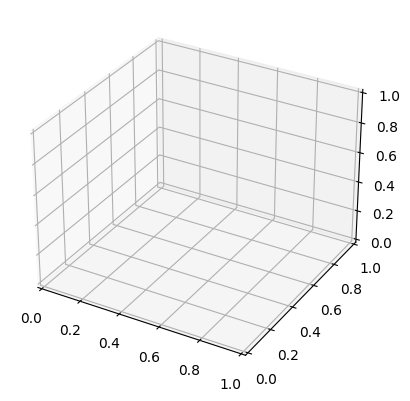

In [ ]:
import matplotlib.animation as animation

# Animate the plot for enthalpy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z1):
        frame = 2*len(z1)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.set_zlim(bottom=np.min(z1), top=np.max(z1))
    surf = ax.plot_surface(x, y, z1[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z1), interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_VariableXimXiv.gif', writer='pillow', fps=5)

### c = c(t)

Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  20
Current frame:  21
Current frame:  22
Current frame:  23
Current frame:  24
Current frame:  25
Current frame:  26
Current frame:  27
Current frame:  28
Current frame:  29
Current frame:  30
Current frame:  31
Current frame:  32
Current frame:  33
Current frame:  34
Current frame:  35
Current frame:  36
Current frame:  37
Current frame:  38
Current frame:  39
Current frame:  0


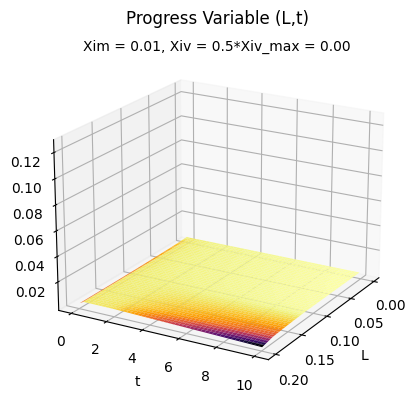

In [ ]:
# Animate the plot for progress variable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z2):
        frame = 2*len(z2)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    ax.set_zlim(bottom=np.min(z2), top=np.max(z2))
    surf = ax.plot_surface(x, y, z2[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z2), interval=200)

# Save the animation as a GIF
ani.save(f'ProgressVariable_VariableXimXiv.gif', writer='pillow', fps=5)

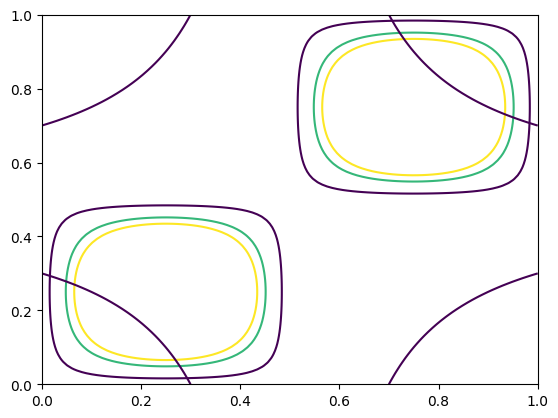

In [185]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X,Y = np.meshgrid(x,y)

Z = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)
W = (X-0.5)**2 * (Y-0.5)**2

plt.contour(X,Y,Z, levels = [0.1,0.3,0.4])
plt.contour(X,Y,W, levels = [0.01]);

## Rotating Plot Animation
Note: some kind of x, y, and z data is needed for this code to work.

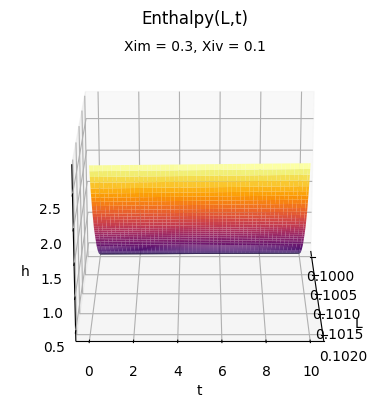

In [12]:
from matplotlib import animation

#----- Animate the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim=4*frame)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    surf = ax.plot_surface(x, y, z1, cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim}, Xiv = {xiv}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=90, interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_xim{xim}_xiv{xiv}.gif', writer='pillow', fps=15)

## Regex Testing

In [ ]:
#Testing Grounds

#Array masking
a = np.ones(10)*(-1)
for i in range(len(a)-1):
    a[i] = np.random.rand()
aNew = a[a!=-1]

#Regex
pattern = r"L_([\d.]+)[SU]_([\d.]+)\.dat"
candidates = ["L_0.03U_198.dat", "L_0.002S_299.dat", "L0990U900.dat"]
for c in candidates:
    print(search(pattern, c))

L = 0.03
pattern2 =  f"L_{L}[SU]_[\d]*\.dat"
arr2 = ["L_0.02S_001.dat", "L_0.02S_003.dat", "L_0.02S_002.dat", "L_0.02U_001.dat", "L_0.03S_001.dat"]
print("Here", len([name for name in arr2 if match(pattern2, name)]))
arr = [0.1, 0.4, 0.5, 0.2, 0.7, 0.15]
print(np.sort(arr)[::-1])

## $\beta$-PDF Endpoint Behavior Testing

In [ ]:
# Fidelity Test: trying to determine the behavior of the BetaPDF near 0 and 1
import LiuInt as LI
from tm2 import phiFuncs
function = phiFuncs("../flame/run", 'T', fileName = 'L_0.002U_24.dat')

#For what value of xim is xim = 0 = x a good approximation? 
#Hypothesis: Something beneath 1e-6 will work fine. 
Min = -1
xim = np.logspace(0, Min,10)
xiv = np.logspace(0, Min,10)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
  
# Creating 2-D grid of features 
[X, Y] = np.meshgrid(xim, xiv) 
  
fig, ax = plt.subplots(1, 1) 

Z = np.zeros((len(xim), len(xiv)))
for i in range(len(xim)):
    for j in range(len(xiv)):
        Z[i,j] = LI.IntegrateForPhiBar(xim[i], xiv[j], function)

# plots filled contour plot 
ax.contourf(X, Y, Z) 
  
ax.set_title('Predicted values') 
ax.set_xlabel('Xim') 
ax.set_xscale('log')
ax.set_ylabel('Xiv')
ax.set_yscale('log')
cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
  
plt.show() 
plt.savefig('Fidelity_min.png', dpi=300, bbox_inches='tight')